In [1]:
from typing import Dict, TypedDict, Annotated, Sequence, List, Tuple, Any
import json
import operator
from typing_extensions import TypedDict

In [7]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, END, START


In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[Any],operator.add]
    query: str
    steps_taken: List[str]
    documents: List[Document]
    retrieval_count: int 
    retrieval_needed: bool 
    self_reflection: str 
    final_answer: str 
    


In [39]:
## create vector store for the documents
def create_vectorstore(documents: List[Document]) -> VectorStoreRetriever:

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(documents)

    vectorstore = Chroma.from_documents(
        documents=splits,
        embedding=OpenAIEmbeddings(),
        collection_name="agentic-rag-docs"
    )

    return vectorstore.as_retriever(search_type = "similarity",search_kwargs={"k": 5})


In [5]:
def initialize_state(query: str) -> AgentState:
    return {
        "messages": [HumanMessage(content=query)],
        "query": query,
        "steps_taken": [],
        "documents": [],
        "retrieval_count": 0,
        "retrieval_needed": True,
        "self_reflection": "",
        "final_answer": ""
    }





In [6]:
## Node for analyzing the query and determining if retrieval is needed

def analyze_query(state: AgentState) -> AgentState:

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="""
        You are an expert query analyzer. Given a user query, determine:
                      1. Whether information retrieval is needed to answer the query
                      2. What specific information would be helpful to retrieve

        Return a structured analysis in JSON format
                      
                      
                      """), MessagesPlaceholder(variable_name="messages")])
    
    class QueryAnalysis(BaseModel):
        retrieval_needed: bool = Field(description="Whether information retrieval is needed to answer the query")
        retrival_keywords: List[str] = Field(description="Keywords that would be helpful for retrueval")
        reasoning: str = Field(description="Explanation of the analysis")

    chain = prompt | llm.with_structured_output(QueryAnalysis) | JsonOutputParser()

    result = chain.invoke({"messages": state["messages"]})

    print(result)

    state["steps_taken"].append("Query analysis")
    state["retrieval_needed"] = result["retrieval_needed"]

    # Add the analysis as a system message
    state["messages"].append(
        SystemMessage(content=f"Query Analysis: {json.dumps(result, indent=2)}")
    )

    return state 

    


In [23]:
## Node for retrieving the documents

def retrieve_documents(state: AgentState, retriever: VectorStoreRetriever) -> AgentState:

    if not state["retrieval_needed"]:
        state["steps_taken"].append("No retrieval needed, retrieval skipped")
        return state 
    
    docs = retriever.invoke(state["query"])

    state["documents"] = docs
    state["retrieval_count"] += 1
    state["steps_taken"].append(f"Document Retrieval (Iteration {state['retrieval_count']})")

    doc_summary = "\n\n".join([f"Document {i+1}: {doc.page_content[:200]}..." for i, doc in enumerate(docs)])

    state["messages"].append(
        SystemMessage(content=f"Retrieved {len(docs)} documents. Document Summary: {doc_summary}")
    )

    return state 




In [24]:
def reflect_on_retrieval(state: AgentState) -> AgentState:
    if not state["retrieval_needed"]:
        return state 
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="""
        You are an expert at evaluating document retrieval quality. Given a user query and retrieved documents,
        evaluate:
        1. How relevant the documents are to the query (score from 1-10)
        2. If the documents provide sufficient information to answer the query
        3. If additional or different retrieval is needed
        
        You must return your evaluation in the following JSON format:
        ```json
        {
            "relevance_score": 7,
            "sufficient_information": true/false,
            "additional_retrieval_needed": true/false,
            "retrieval_feedback": "Your detailed feedback on the retrieval quality",
            "suggested_keywords": ["keyword1", "keyword2", ...]
        }
        ```
        
        """), MessagesPlaceholder(variable_name="messages"),
        SystemMessage(content="User Query: {query}"),
        SystemMessage(content="Retrieved Documents: {documents_content}"),])
    
    class RetrievalEvaluation(BaseModel):
        relevance_score: int = Field(description="Score from 1-10 indicating relevance")
        sufficient_information: bool = Field(description="Whether the documents provide sufficient information")
        additional_retrieval_needed: bool = Field(description="Whether additional retrieval is needed")
        retrieval_feedback: str = Field(description="Detailed feedback on the retrieval quality")
        suggested_keywords: List[str] = Field(description="Keywords that would be helpful for additional retrueval")

    chain = prompt | llm.with_structured_output(RetrievalEvaluation) | JsonOutputParser()

    docs_content =  "\n\n".join([f"Document {i+1}: {doc.page_content}" for i, doc in enumerate(state["documents"])])

    result = chain.invoke( {"messages": state["messages"],
        "query": state["query"],
        "documents_content": docs_content
    })


    state["steps_taken"].append("Retrieval Self-Reflection")

    state["retrieval_needed"] = result["additional_retrieval_needed"]
    state["self_reflection"] = result["retrieval_feedback"]

    state["messages"].append(SystemMessage(content=f"Retrieval Evaluation: {json.dumps(result, indent=2)}"))

    if state["retrieval_needed"] and state["retrieval_count"] >= 3:
        state["retrieval_needed"] = False
        state["messages"].append(SystemMessage(content="""Maximum retrieval attempts reached. Providing with available information."""))


    return state 

        
    


In [25]:
def generate_answer(state: AgentState) -> AgentState:

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    prompt = ChatPromptTemplate.from_messages([

        SystemMessage(content="""
        You are a knowledgeable assistant that provides comprehensive and accurate answers.
        Use the retrieved documents to formulate your response, but also draw on your general knowledge
        when appropriate. Be specific and cite information from the documents when possible.
        
        If the retrieved documents don't provide enough information, acknowledge the limitations
        and provide the best answer you can with the available information.
        """),
        MessagesPlaceholder(variable_name="messages"),
        SystemMessage(content="User Query: {query}"),
        SystemMessage(content="Retrieved Documents: {documents_content}"),
        SystemMessage(content="Retrieval Self-Reflection: {self_reflection}")
    ])

    docs_content = "\n\n".join([f"Document {i+1}: {doc.page_content}" for i, doc in enumerate(state["documents"])])

    responce = prompt | llm 

    result = responce.invoke({
        "messages": state["messages"],
        "query": state["query"],
        "documents_content": docs_content,
        "self_reflection": state["self_reflection"]
    })

    state["steps_taken"].append("Answer Generation")
    state["final_answer"] = result.content
    state["messages"].append(AIMessage(content=result.content))

    return state 


In [41]:
def create_agent_graph(retriever: VectorStoreRetriever) -> StateGraph:
    workflow = StateGraph(AgentState)

    workflow.add_node("analyze_query", analyze_query)
    workflow.add_node("retrieve_documents", lambda state: retrieve_documents(state, retriever))
    workflow.add_node("reflect_on_retrieval", reflect_on_retrieval)
    workflow.add_node("generate_answer", generate_answer)

    # Define routing functions
    def should_retrieve(state: AgentState) -> str:
        return "retrieve_documents" if state["retrieval_needed"] else "generate_answer"

    def should_continue_retrieval(state: AgentState) -> str:
        return "retrieve_documents" if state["retrieval_needed"] else "generate_answer"

    workflow.add_edge(START, "analyze_query")

    workflow.add_conditional_edges("analyze_query", should_retrieve,{
            "retrieve_documents": "retrieve_documents", 
            "generate_answer": "generate_answer"
        })

    workflow.add_edge("retrieve_documents", "reflect_on_retrieval")
    workflow.add_conditional_edges("reflect_on_retrieval", should_continue_retrieval,{
            "retrieve_documents": "retrieve_documents",
            "generate_answer": "generate_answer"
        })

    workflow.add_edge("generate_answer", END)

    agent = workflow.compile()

    return agent


In [44]:
def run_rag_agent(query:str, documents: List[Document]):

    retriever = create_vectorstore(documents)

    agent = create_agent_graph(retriever)

    state = initialize_state(query)

    final_state = agent.invoke(state)

    return final_state

    


In [ ]:
sample_docs = [
        Document(page_content="The capital of india is Kolkata", metadata={"source": "docs/India/intro.md"}),
        Document(page_content="The capital of France is Paris", metadata={"source": "docs/France/intro.md"}),
        Document(page_content="The capital of Germany is Berlin", metadata={"source": "docs/Germany/intro.md"}),
        Document(page_content="The capital of Italy is Rome", metadata={"source": "docs/Italy/intro.md"}),
        Document(page_content="The capital of Spain is Madrid", metadata={"source": "docs/Spain/intro.md"}),
        Document(page_content="The capital of Portugal is Lisbon", metadata={"source": "docs/Portugal/intro.md"}),]
        
query = "What is the capital of France?"


In [ ]:
result = run_rag_agent(query, sample_docs)

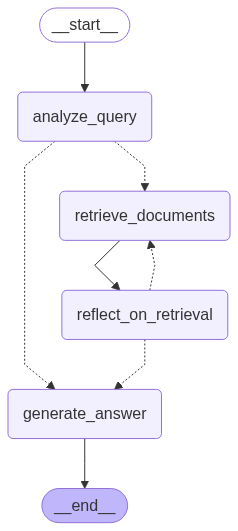

In [35]:
from IPython.display import Image, display
display(agent)